# Ranking Heuristics & Graph-Based Signals

Evaluation of the non-learned ranking signals

## 1. Imports and Data Loading

In [2]:
!git clone https://$GITHUB_TOKEN@github.com/Its-OP/ucu-rs-2026.git

Cloning into 'ucu-rs-2026'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 436 (delta 134), reused 170 (delta 80), pack-reused 168 (from 1)
Receiving objects: 100% (436/436), 79.41 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [3]:
%cd ucu-rs-2026

/content/ucu-rs-2026


In [12]:
import os
import ast
import random
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

from data.dataframes import train, val, test, users, movies
from src.eval.eval import evaluate as evaluate_basic
from src.eval.offline_ranking import evaluate as evaluate_offline

from src.models.popularity import (
    PopularityRanker,
    MeanRatingRanker,
    BayesianPopularityRanker,
    RecencyPopularityRanker,
)
from src.models.graph import (
    ItemGraphPropagationRanker,
    PageRankRanker,
    PersonalizedPageRankRanker,
)

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("src.eval.eval").setLevel(logging.ERROR)
logging.getLogger("src.eval.offline_ranking").setLevel(logging.ERROR)

In [5]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

## 2. Model Factory

All the implementations are in the repository

In [6]:
def build_model(name, params):
    if name == "count":
        return PopularityRanker()
    if name == "mean_rating":
      return MeanRatingRanker(min_count=params["min_count"])
    if name == "bayesian":
        return BayesianPopularityRanker(bayesian_m=params["bayesian_m"])
    if name == "recency":
        return RecencyPopularityRanker(half_life_days=params["half_life_days"])
    if name == "item_graph":
        return ItemGraphPropagationRanker(
            relevance_threshold=params["graph_threshold"],
            use_rating_weights=params["graph_use_rating_weights"],
            alpha=params["graph_alpha"],
            n_steps=params["graph_steps"],
        )
    if name == "pagerank":
        return PageRankRanker(
            relevance_threshold=params["graph_threshold"],
            use_rating_weights=params["graph_use_rating_weights"],
            damping=params["graph_damping"],
            max_iter=params["graph_max_iter"],
            tol=params["graph_tol"],
        )
    if name == "ppr":
        return PersonalizedPageRankRanker(
            relevance_threshold=params["graph_threshold"],
            use_rating_weights=params["graph_use_rating_weights"],
            damping=params["graph_damping"],
            max_iter=params["graph_max_iter"],
            tol=params["graph_tol"],
        )
    raise ValueError(name)

## 3. Hyperparameter Configurations

##### `count` (Popularity by count)

* **Idea:** rank items by global interaction count.
* **Parameters:** none.

##### `mean_rating` (Mean rating baseline)

* **Idea:** rank items by (weighted) mean rating.
* **Parameters:**

  * `min_count`: minimum number of interactions required to include an item in ranking (`0` = no filter, high variance; larger values stabilize).

##### `bayesian` (Bayesian-smoothed mean rating)

* **Idea:** rank items by mean rating shrunk toward the global mean to reduce noise for low-support items.
* **Parameters:**

  * `bayesian_m`: pseudo-count strength (higher = more smoothing, lower = closer to raw mean).

##### `recency` (Recency-decayed popularity)

* **Idea:** rank items by popularity with exponential time decay on interactions.
* **Parameters:**

  * `half_life_days`: decay half-life in days (smaller = more “trending”, larger = closer to standard popularity).

##### `item_graph` (Item–item propagation)

* **Idea:** build an item graph from positive interactions and propagate user preference from seed items to neighbors.
* **Parameters:**

  * `graph_threshold`: rating threshold to treat an interaction as positive (fixed at `4.0`).
  * `graph_use_rating_weights`: whether to weight edges/contributions by rating magnitude (`True/False`).
  * `graph_alpha`: propagation strength / retention factor.
  * `graph_steps`: number of propagation steps (hops).

##### `pagerank` (Global PageRank)

* **Idea:** compute a global item centrality score via PageRank on the graph (non-personalized).
* **Parameters:**

  * `graph_threshold`: positive interaction threshold (fixed at `4.0`).
  * `graph_use_rating_weights`: whether to weight edges by rating magnitude (`True/False`).
  * `graph_damping`: damping factor for the random walk.
  * `graph_max_iter`: maximum iterations for convergence.
  * `graph_tol`: convergence tolerance.

##### `ppr` (Personalized PageRank)

* **Idea:** compute a personalized PageRank score per user with restarts to the user’s seed set (personalized graph signal).
* **Parameters:**

  * `graph_threshold`: positive interaction threshold (fixed at `4.0`).
  * `graph_use_rating_weights`: whether to weight edges by rating magnitude (`True/False`).
  * `graph_damping`: damping factor for the random walk.
  * `graph_max_iter`: maximum iterations per user.
  * `graph_tol`: convergence tolerance.


In [19]:
configs = []

configs.append(("count", {}))

configs.append(("mean_rating", {"min_count": 0}))
for mc in [5, 20, 50]:
    configs.append(("mean_rating", {"min_count": mc}))

for m in [10, 25, 50, 100]:
    configs.append(("bayesian", {"bayesian_m": m}))

for hl in [3, 7, 14, 30, 60]:
    configs.append(("recency", {"half_life_days": hl}))

for thr, w, a, s in product([4.0], [False, True], [0.70, 0.85, 0.95], [1, 2, 3]):
    configs.append(("item_graph", {
        "graph_threshold": thr,
        "graph_use_rating_weights": w,
        "graph_alpha": a,
        "graph_steps": s,
    }))

for thr, w, d in product([4.0], [False, True], [0.70, 0.85, 0.95]):
    configs.append(("pagerank", {
        "graph_threshold": thr,
        "graph_use_rating_weights": w,
        "graph_damping": d,
        "graph_max_iter": 100,
        "graph_tol": 1e-8,
    }))

for thr, w, d in product([4.0], [False, True], [0.70, 0.85, 0.95]):
    configs.append(("ppr", {
        "graph_threshold": thr,
        "graph_use_rating_weights": w,
        "graph_damping": d,
        "graph_max_iter": 50,
        "graph_tol": 1e-7,
    }))

## 4. Evaluation on VAL subset

### 4.1 Helpers

In [13]:
def _normalize_params(x):
    """CSV/DF safety: ensure params is a dict (sometimes stored as string)."""
    if isinstance(x, dict):
        return x
    if isinstance(x, str) and x.strip():
        try:
            return ast.literal_eval(x)
        except Exception:
            return {"raw": x}
    return {}

def _params_to_str(d: dict) -> str:
    if not d:
        return ""
    items = sorted(d.items(), key=lambda kv: kv[0])
    return ",".join([f"{k}={v}" for k, v in items])

def make_config_label(model: str, params) -> str:
    params = _normalize_params(params)
    p = _params_to_str(params)
    return f"{model}" if not p else f"{model} ({p})"

def family_of(model_name: str) -> str:
    if model_name in {"count", "mean_rating", "bayesian", "recency"}:
        return "popularity"
    if model_name in {"item_graph", "pagerank", "ppr"}:
        return "graph"
    return "other"

### 4.2 Run Experiments

In [20]:
rows = []
for model_name, params in configs:
    model = build_model(model_name, params)
    model.fit(train, users=users, movies=movies)

    report = evaluate_offline(
        model=model,
        train_ratings=train,
        test_ratings=val,
        users=users,
        movies=movies,
        ks=[10, 20],
        threshold=4.0,
        mode="all",
    )

    base = {
        "model": model_name,
        "params": params,
        "mode": report.mode,
        "n_users_total": report.n_users_total,
        "n_users_with_gt": report.n_users_with_gt,
        "n_users_eligible": report.n_users_eligible,
        "n_users_evaluated": report.n_users_evaluated,
        "n_predicted": report.n_predicted,
        "n_skipped": report.n_skipped,
        "skip_rate": report.skip_rate,
        "coverage_rate": report.coverage_rate,
        "avg_list_size": report.avg_list_size,
        "cold_user_rate": report.cold_user_rate,
    }

    for k, mk in report.by_k.items():
        row = base.copy()
        row.update({
            "k": k,
            "ndcg": mk.ndcg,
            "precision": mk.precision,
            "recall": mk.recall,
            "mrr": mk.mrr,
        })
        rows.append(row)

val_offline_df = (
    pd.DataFrame(rows)
    .sort_values(["k", "ndcg"], ascending=[True, False])
    .reset_index(drop=True)
)

**Model identification**

* `model`
  the model variant name (e.g., `count`, `bayesian`, `recency`, `item_graph`, `pagerank`, `ppr`).

* `params`
  hyperparameters for this model configuration (stored as a Python dict).

* `mode`
  User-subset mode used by the evaluator:

  * `all`: evaluate on all users passed to the model.
  * `warm_only`: evaluate only on "warm" users (users with sufficient training history under the evaluator’s definition).

---

**User accounting (who is included)**

* `n_users_total`
  total number of users provided to the evaluation.

* `n_users_with_gt`
  number of users who have at least one interaction in the evaluation split (appear in *test_ratings* with at least one row, regardless of rating value).

* `n_users_eligible`
  number of users who have at least one relevant item in the evaluation split (according to the relevance threshold); only these users can meaningfully contribute to Precision/Recall/MRR.

* `n_users_evaluated`
  number of users actually used in metric averaging (shoud be equal to `n_users_eligible` after skipping ineligible users).

* `n_predicted`
  number of users for whom the model produced a prediction list.

* `n_skipped`
  number of users excluded from evaluation (most commonly because they have no relevant items in the evaluation split).

* `skip_rate`
  fraction of predicted users that were skipped: $\text{skip_rate}=\frac{n_skipped}{n_predicted}$.

---

**Recommendation list diagnostics**

* `coverage_rate`
  fraction of users who received a non-empty recommendation list: $\text{coverage_rate}=\frac{{\text{users with }|\text{rec_list}|>0}}{n_users_total}$.

* `avg_list_size`
  Average number of recommended items returned per user; often close to the maximum requested $K$, but can be smaller if filtering ("seen-item masking") removes many candidates.

* `cold_user_rate`
  fraction of users considered cold-start with insufficient training history to support personalization.

---

**Ranking metrics**

* `k`
  The cutoff used for ranking metrics.

* `ndcg` (NDCG@K)
  Normalized Discounted Cumulative Gain at `k`: measures ranking quality with stronger emphasis on top positions.

* `precision` (Precision@K)
  fraction of recommended items in top-`k` that are relevant: $\text{Precision@K}=\frac{{\text{relevant items in top-K}}}{K}$.

* `recall` (Recall@K)
  fraction of relevant test items retrieved in top-`k`: $\text{Recall@K}=\frac{{\text{relevant items in top-K}}}{{\text{relevant items in test}}}$

* `mrr` (MRR@K)
  Mean Reciprocal Rank at `k`: for each user, find the rank $r$ of the first relevant recommendation (within top-$k$), assign $1/r$ (or $0$ if none), then average across evaluated users.


In [21]:
val_offline_df

,model,params,mode,n_users_total,n_users_with_gt,n_users_eligible,n_users_evaluated,n_predicted,n_skipped,skip_rate,coverage_rate,avg_list_size,cold_user_rate,k,ndcg,precision,recall,mrr
0,count,{},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,10,0.296224,0.262082,0.054551,0.473669
1,recency,{'half_life_days': 60},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,10,0.295934,0.259538,0.053923,0.472092
2,recency,{'half_life_days': 3},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,10,0.295482,0.263666,0.055238,0.460966
3,recency,{'half_life_days': 30},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,10,0.295235,0.259547,0.054067,0.472020
4,recency,{'half_life_days': 7},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,10,0.292912,0.259554,0.053757,0.457918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,bayesian,{'bayesian_m': 10},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,20,0.127204,0.122111,0.040664,0.214792
84,mean_rating,{'min_count': 50},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,20,0.109169,0.104735,0.035121,0.200597
85,mean_rating,{'min_count': 20},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,20,0.104361,0.103033,0.034184,0.191385
86,mean_rating,{'min_count': 5},all,6040,1223,1188,1188,6040,4852,0.803311,1.0,20.0,0.149834,20,0.083532,0.094415,0.030951,0.100072


### 4.3 Result Visualization

In [15]:
# prepare data
df = val_offline_df.copy()

df["params"] = df["params"].apply(_normalize_params)
df["config"] = df.apply(lambda r: make_config_label(r["model"], r["params"]), axis=1)
df["family"] = df["model"].map(family_of)

MODE = "all"
KS = [10, 20]
TOPN = 15
TOPM = 10

dfm = df[(df["mode"] == MODE) & (df["k"].isin(KS))].copy()

In [16]:
# top-N table by NDCG@10
top10 = (
    dfm[dfm["k"] == 10]
    .sort_values(["ndcg", "mrr"], ascending=[False, False])
    .head(TOPN)
    .reset_index(drop=True)
)

display_cols = [
    "family", "model", "params", "ndcg", "mrr", "precision", "recall",
    "skip_rate", "coverage_rate", "n_users_evaluated"
]
print(f"Top {TOPN} configs on VAL (mode={MODE}) by NDCG@10:")
display(top10[display_cols])

Top 15 configs on VAL (mode=all) by NDCG@10:


,family,model,params,ndcg,mrr,precision,recall,skip_rate,coverage_rate,n_users_evaluated
0,popularity,count,{},0.296224,0.473669,0.262082,0.054551,0.803311,1.0,1188
1,popularity,recency,{'half_life_days': 60},0.295934,0.472092,0.259538,0.053923,0.803311,1.0,1188
2,popularity,recency,{'half_life_days': 3},0.295482,0.460966,0.263666,0.055238,0.803311,1.0,1188
3,popularity,recency,{'half_life_days': 30},0.295235,0.472020,0.259547,0.054067,0.803311,1.0,1188
4,popularity,recency,{'half_life_days': 7},0.292912,0.457918,0.259554,0.053757,0.803311,1.0,1188
5,popularity,recency,{'half_life_days': 14},0.292886,0.457821,0.259054,0.053636,0.803311,1.0,1188
6,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.291610,0.447596,0.266307,0.056036,0.803311,1.0,1188
7,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.291610,0.447596,0.266307,0.056036,0.803311,1.0,1188
8,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.291610,0.447596,0.266307,0.056036,0.803311,1.0,1188
9,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.288776,0.439604,0.264744,0.055820,0.803311,1.0,1188


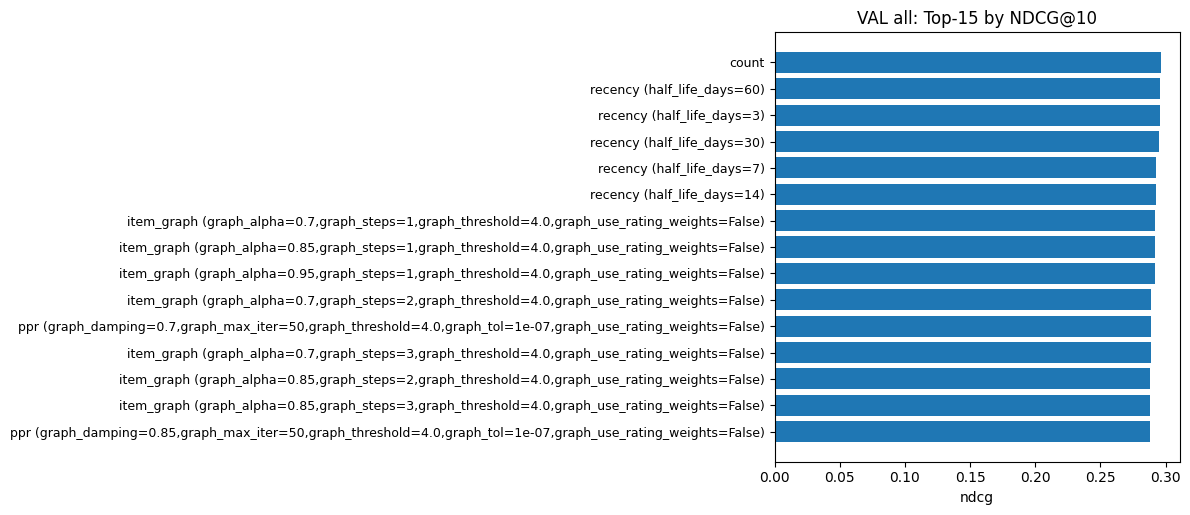

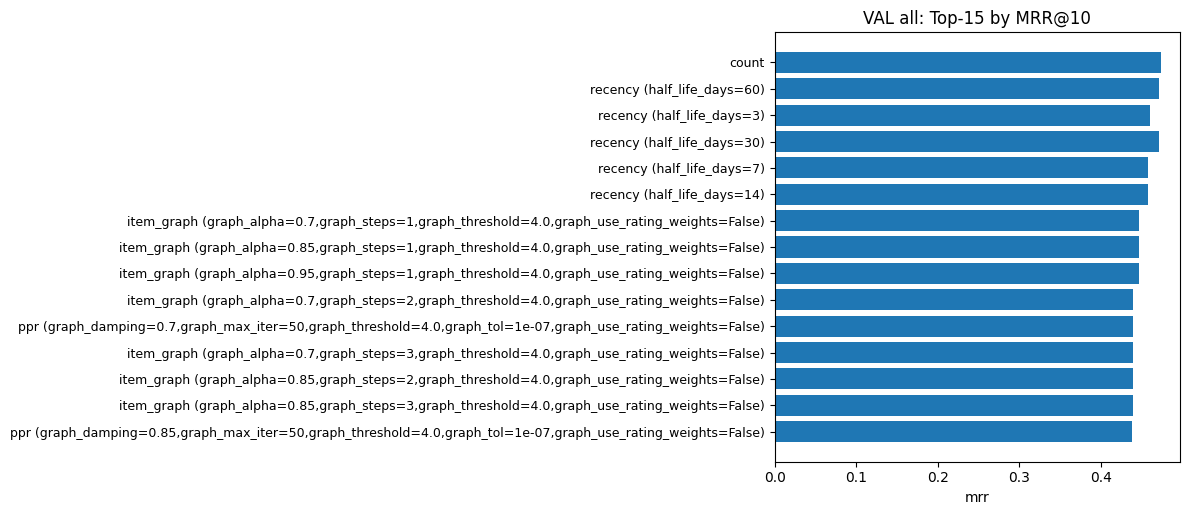

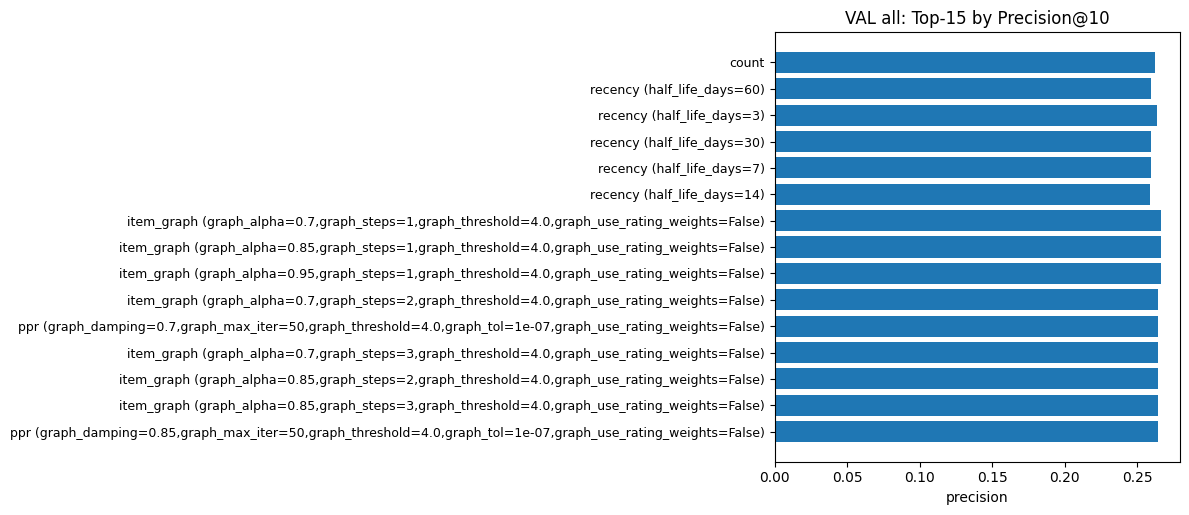

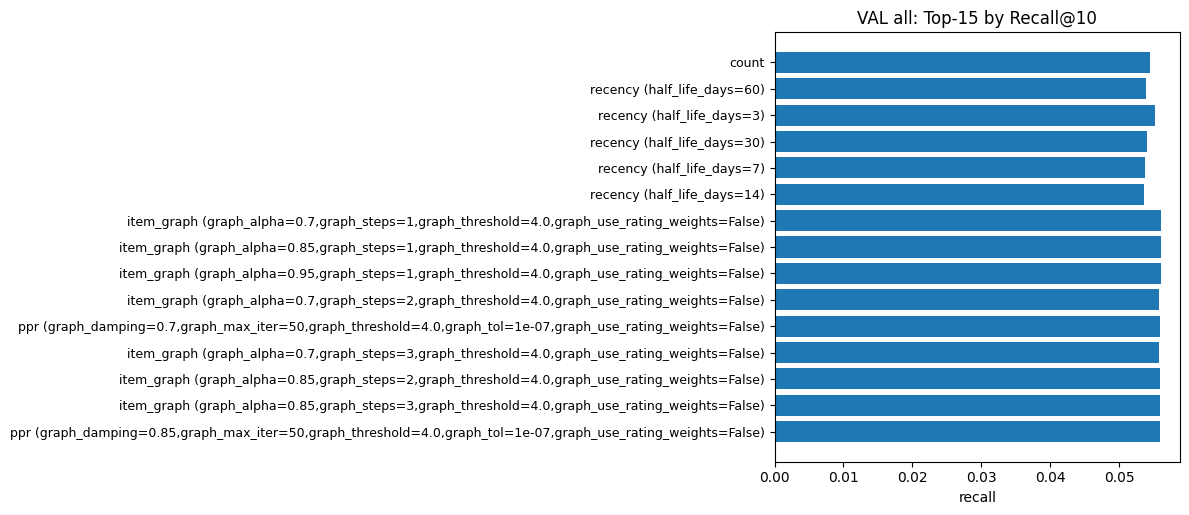

In [17]:
# bar charts for Top-N @10
def plot_topn_bars(df_top, metric: str, title: str):
    labels = df_top["config"].tolist()
    vals = df_top[metric].astype(float).to_numpy()

    plt.figure(figsize=(12, max(4, 0.35 * len(labels))))
    y = np.arange(len(labels))
    plt.barh(y, vals)
    plt.yticks(y, labels, fontsize=9)
    plt.gca().invert_yaxis()
    plt.xlabel(metric)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_topn_bars(top10, "ndcg", f"VAL {MODE}: Top-{TOPN} by NDCG@10")
plot_topn_bars(top10, "mrr", f"VAL {MODE}: Top-{TOPN} by MRR@10")
plot_topn_bars(top10, "precision", f"VAL {MODE}: Top-{TOPN} by Precision@10")
plot_topn_bars(top10, "recall", f"VAL {MODE}: Top-{TOPN} by Recall@10")

In [19]:
# K=10 vs K=20 comparison for the same configs (Top-M by NDCG@10)
topM_configs = top10.head(TOPM)["config"].tolist()

pivot_ndcg = (
    dfm[dfm["config"].isin(topM_configs)]
    .pivot_table(index="config", columns="k", values="ndcg", aggfunc="first")
    .reindex(topM_configs)
)

print(f"NDCG@10 vs NDCG@20 for top-{TOPM} configs:")
display(pivot_ndcg)

NDCG@10 vs NDCG@20 for top-10 configs:


k,10,20
config,,
count,0.296224,0.284371
recency (half_life_days=60),0.295934,0.283872
recency (half_life_days=3),0.295482,0.282847
recency (half_life_days=30),0.295235,0.283070
recency (half_life_days=7),0.292912,0.281189
recency (half_life_days=14),0.292886,0.281109
"item_graph (graph_alpha=0.7,graph_steps=1,graph_threshold=4.0,graph_use_rating_weights=False)",0.291610,0.278821
"item_graph (graph_alpha=0.85,graph_steps=1,graph_threshold=4.0,graph_use_rating_weights=False)",0.291610,0.278821
"item_graph (graph_alpha=0.95,graph_steps=1,graph_threshold=4.0,graph_use_rating_weights=False)",0.291610,0.278821


In [20]:
pivot_recall = (
    dfm[dfm["config"].isin(topM_configs)]
    .pivot_table(index="config", columns="k", values="recall", aggfunc="first")
    .reindex(topM_configs)
)

print(f"Recall@10 vs Recall@20 for top-{TOPM} configs:")
display(pivot_recall)

Recall@10 vs Recall@20 for top-10 configs:


k,10,20
config,,
count,0.054551,0.087626
recency (half_life_days=60),0.053923,0.087066
recency (half_life_days=3),0.055238,0.086732
recency (half_life_days=30),0.054067,0.086524
recency (half_life_days=7),0.053757,0.086532
recency (half_life_days=14),0.053636,0.086205
"item_graph (graph_alpha=0.7,graph_steps=1,graph_threshold=4.0,graph_use_rating_weights=False)",0.056036,0.088172
"item_graph (graph_alpha=0.85,graph_steps=1,graph_threshold=4.0,graph_use_rating_weights=False)",0.056036,0.088172
"item_graph (graph_alpha=0.95,graph_steps=1,graph_threshold=4.0,graph_use_rating_weights=False)",0.056036,0.088172


In [23]:
# best-per-model and best-per-family tables (on k=10)
df10 = dfm[dfm["k"] == 10].copy()

best_per_model = (
    df10.sort_values(["model", "ndcg", "mrr"], ascending=[True, False, False])
       .groupby("model", as_index=False)
       .head(1)
       .sort_values(["family", "ndcg"], ascending=[True, False])
       .reset_index(drop=True)
)

best_per_family = (
    df10.sort_values(["family", "ndcg", "mrr"], ascending=[True, False, False])
       .groupby("family", as_index=False)
       .head(1)
       .sort_values(["ndcg"], ascending=False)
       .reset_index(drop=True)
)

print("Best per MODEL on VAL (k=10):")
display(best_per_model[["family", "model", "params", "ndcg", "mrr", "precision", "recall",
                        "skip_rate", "coverage_rate", "n_users_evaluated"]])
print("\n")
print("Best per FAMILY on VAL (k=10):")
display(best_per_family[["family", "model", "params", "ndcg", "mrr", "precision", "recall",
                         "skip_rate", "coverage_rate", "n_users_evaluated"]])

Best per MODEL on VAL (k=10):


,family,model,params,ndcg,mrr,precision,recall,skip_rate,coverage_rate,n_users_evaluated
0,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.291610,0.447596,0.266307,0.056036,0.803311,1.0,1188
1,graph,ppr,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.288611,0.439608,0.264744,0.055906,0.803311,1.0,1188
2,graph,pagerank,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.286597,0.435087,0.263034,0.055436,0.803311,1.0,1188
3,popularity,count,{},0.296224,0.473669,0.262082,0.054551,0.803311,1.0,1188
4,popularity,recency,{'half_life_days': 60},0.295934,0.472092,0.259538,0.053923,0.803311,1.0,1188
5,popularity,bayesian,{'bayesian_m': 100},0.184607,0.327805,0.168192,0.031779,0.803311,1.0,1188
6,popularity,mean_rating,{'min_count': 50},0.109751,0.191620,0.113932,0.021340,0.803311,1.0,1188




Best per FAMILY on VAL (k=10):


,family,model,params,ndcg,mrr,precision,recall,skip_rate,coverage_rate,n_users_evaluated
0,popularity,count,{},0.296224,0.473669,0.262082,0.054551,0.803311,1.0,1188
1,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",0.291610,0.447596,0.266307,0.056036,0.803311,1.0,1188


## Evaluation on TEST subset

Only best hypermeter configs per model type and per family

### 5.1 Evaluation Best Models per Type

In [25]:
TEST_MODE = "all"
TEST_KS = [10, 20]
THRESHOLD = 4.0

test_rows = []

for _, row in best_per_model.iterrows():
    model_name = row["model"]
    params = row["params"]

    model = build_model(model_name, params)
    model.fit(train, users=users, movies=movies)

    report_test = evaluate_offline(
        model=model,
        train_ratings=train,
        test_ratings=test,
        users=users,
        movies=movies,
        ks=TEST_KS,
        threshold=THRESHOLD,
        mode=TEST_MODE,
    )

    for k, mk in report_test.by_k.items():
        test_rows.append({
            "model": model_name,
            "params": params,
            "mode": report_test.mode,
            "split": "test",
            "k": int(k),
            "ndcg": float(mk.ndcg),
            "mrr": float(mk.mrr),
            "precision": float(mk.precision),
            "recall": float(mk.recall),

            "n_users_total": report_test.n_users_total,
            "n_users_with_gt": report_test.n_users_with_gt,
            "n_users_eligible": report_test.n_users_eligible,
            "n_users_evaluated": report_test.n_users_evaluated,
            "n_predicted": report_test.n_predicted,
            "n_skipped": report_test.n_skipped,
            "skip_rate": report_test.skip_rate,
            "coverage_rate": report_test.coverage_rate,
            "avg_list_size": report_test.avg_list_size,
            "cold_user_rate": report_test.cold_user_rate,
        })

test_best_per_model_df = (
    pd.DataFrame(test_rows)
    .sort_values(["k", "ndcg"], ascending=[True, False])
    .reset_index(drop=True)
)

In [26]:
test_best_per_model_df

,model,params,mode,split,k,ndcg,mrr,precision,recall,n_users_total,n_users_with_gt,n_users_eligible,n_users_evaluated,n_predicted,n_skipped,skip_rate,coverage_rate,avg_list_size,cold_user_rate
0,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",all,test,10,0.235137,0.368333,0.212660,0.048792,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
1,ppr,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",all,test,10,0.226483,0.356738,0.203536,0.045453,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
2,pagerank,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",all,test,10,0.221957,0.350455,0.199373,0.044251,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
3,count,{},all,test,10,0.217272,0.351043,0.192658,0.042055,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
4,recency,{'half_life_days': 60},all,test,10,0.214137,0.347165,0.189333,0.041705,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
5,bayesian,{'bayesian_m': 100},all,test,10,0.159757,0.295341,0.142135,0.029668,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
6,mean_rating,{'min_count': 50},all,test,10,0.099043,0.173366,0.100020,0.020247,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
7,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",all,test,20,0.223923,0.375044,0.191321,0.072909,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
8,ppr,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",all,test,20,0.216632,0.363197,0.183536,0.068660,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834
9,pagerank,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",all,test,20,0.212277,0.356728,0.180391,0.067221,6040,1367,1347,1347,6040,4693,0.776987,1.0,20.0,0.149834


### 5.2 Evaluation Best Models per Family [All vs Warm]

In [27]:
TEST_KS = [10, 20]
THRESHOLD = 4.0
MODES = ["all", "warm_only"]

rows = []

for _, r in best_per_family.iterrows():
    fam = r["family"]
    model_name = r["model"]
    params = r["params"]

    model = build_model(model_name, params)
    model.fit(train, users=users, movies=movies)

    for mode in MODES:
        report = evaluate_offline(
            model=model,
            train_ratings=train,
            test_ratings=test,
            users=users,
            movies=movies,
            ks=TEST_KS,
            threshold=THRESHOLD,
            mode=mode,
        )

        for k, mk in report.by_k.items():
            rows.append({
                "family": fam,
                "model": model_name,
                "params": params,
                "split": "test",
                "mode": report.mode,
                "k": int(k),
                "ndcg": float(mk.ndcg),
                "mrr": float(mk.mrr),
                "precision": float(mk.precision),
                "recall": float(mk.recall),

                "n_users_total": report.n_users_total,
                "n_users_with_gt": report.n_users_with_gt,
                "n_users_eligible": report.n_users_eligible,
                "n_users_evaluated": report.n_users_evaluated,
                "skip_rate": report.skip_rate,
                "coverage_rate": report.coverage_rate,
                "cold_user_rate": report.cold_user_rate,
            })

warm_vs_all_df = pd.DataFrame(rows).sort_values(["family", "k", "mode"]).reset_index(drop=True)

In [28]:
warm_vs_all_df

,family,model,params,split,mode,k,ndcg,mrr,precision,recall,n_users_total,n_users_with_gt,n_users_eligible,n_users_evaluated,skip_rate,coverage_rate,cold_user_rate
0,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",test,all,10,0.235137,0.368333,0.212660,0.048792,6040,1367,1347,1347,0.776987,1.0,0.149834
1,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",test,warm_only,10,0.223234,0.357627,0.198550,0.050571,6040,983,968,968,0.811490,1.0,0.149834
2,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",test,all,20,0.223923,0.375044,0.191321,0.072909,6040,1367,1347,1347,0.776987,1.0,0.149834
3,graph,item_graph,"{'graph_threshold': 4.0, 'graph_use_rating_wei...",test,warm_only,20,0.211464,0.364860,0.175807,0.073013,6040,983,968,968,0.811490,1.0,0.149834
4,popularity,count,{},test,all,10,0.217272,0.351043,0.192658,0.042055,6040,1367,1347,1347,0.776987,1.0,0.149834
5,popularity,count,{},test,warm_only,10,0.198162,0.323717,0.173864,0.042113,6040,983,968,968,0.811490,1.0,0.149834
6,popularity,count,{},test,all,20,0.210401,0.358516,0.175673,0.065788,6040,1367,1347,1347,0.776987,1.0,0.149834
7,popularity,count,{},test,warm_only,20,0.191382,0.330627,0.154817,0.063166,6040,983,968,968,0.811490,1.0,0.149834


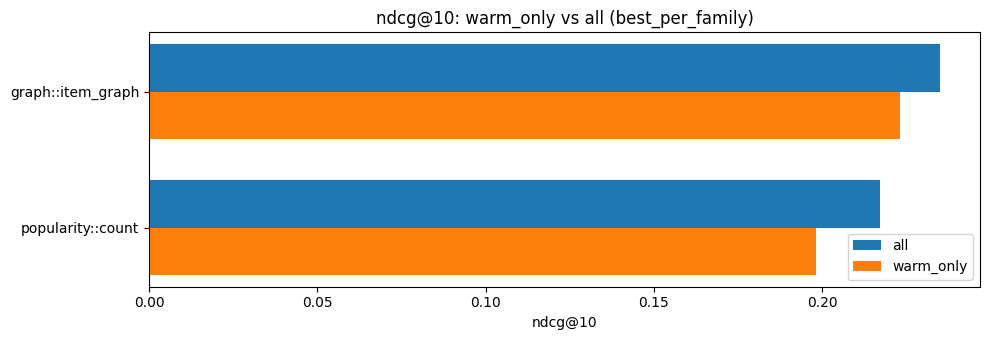

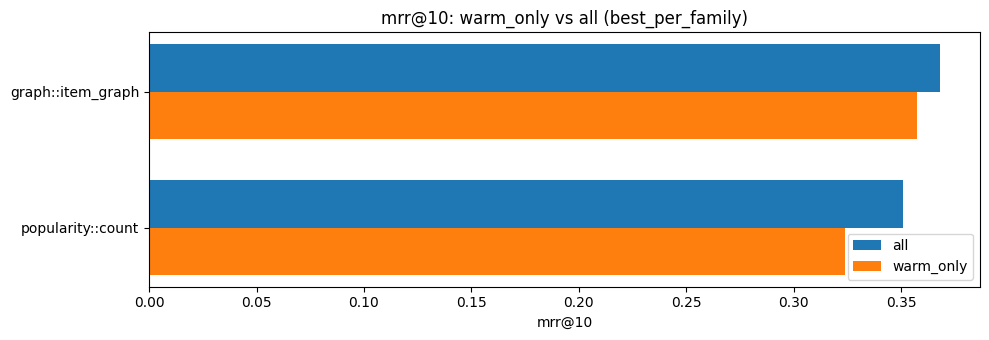

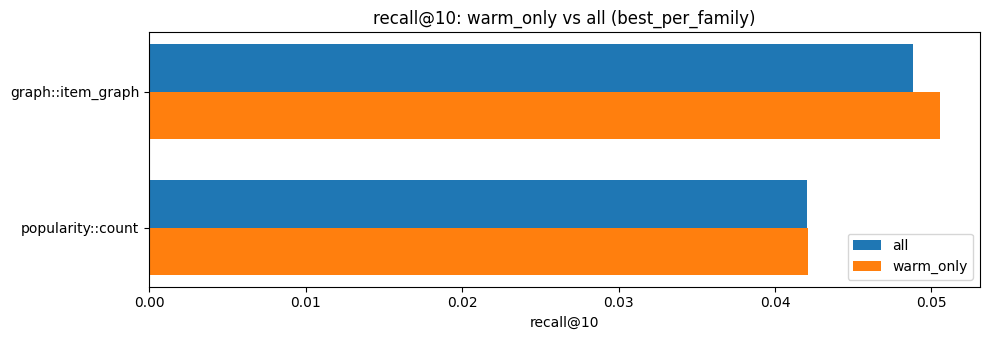

In [30]:
def plot_metric_warm_all(df: pd.DataFrame, metric: str, k: int):
    sub = df[df["k"] == k].copy()
    order = (
        sub[sub["mode"] == "all"]
        .sort_values(["family", metric], ascending=[True, False])
        [["family", "model"]]
        .apply(lambda x: f"{x['family']}::{x['model']}", axis=1)
        .tolist()
    )

    def key(row):
        return f"{row['family']}::{row['model']}"

    sub["key"] = sub.apply(key, axis=1)
    sub["key"] = pd.Categorical(sub["key"], categories=order, ordered=True)

    p = sub.pivot_table(index="key", columns="mode", values=metric, aggfunc="first").reindex(order)

    plt.figure(figsize=(10, max(3.5, 0.4 * len(order))))
    y = np.arange(len(order))
    bar_w = 0.35
    plt.barh(y - bar_w/2, p["all"].values, height=bar_w, label="all")
    plt.barh(y + bar_w/2, p["warm_only"].values, height=bar_w, label="warm_only")
    plt.yticks(y, order, fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel(f"{metric}@{k}")
    plt.title(f"{metric}@{k}: warm_only vs all (best_per_family)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric_warm_all(warm_vs_all_df, metric="ndcg", k=10)
plot_metric_warm_all(warm_vs_all_df, metric="mrr", k=10)
plot_metric_warm_all(warm_vs_all_df, metric="recall", k=10)